In [38]:
!pip install opencv-python

In [39]:
import os
os.sys.path
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import constants
import Lane
import Functions

myImage = cv2.imread("test_images/test3.jpg")
myImage = cv2.cvtColor(myImage, cv2.COLOR_BGR2RGB)

In [40]:
with open('dist_pickle.p', 'rb') as f:
    parameters = pickle.load(f)
    cameraMatrix = parameters['mtx']
    distortionCoefficients = parameters['dist']

# Step 1: Image Undistortion

Text(0.5, 1.0, 'Undistort the Image')

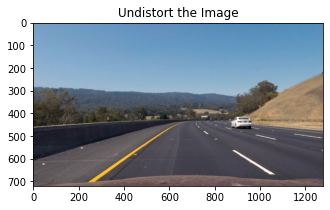

In [41]:
def undistortImage(myImage, cameraMatrix, distortionCoefficientsortionCoefficients):
    return cv2.undistort(myImage, cameraMatrix, distortionCoefficientsortionCoefficients, None, cameraMatrix)

undistortedImage = undistortImage(myImage, cameraMatrix, distortionCoefficients)
f, ax = plt.subplots(figsize=(12, 3))
ax.imshow(undistortedImage)
ax.set_title('Undistort the Image')

# Step 2: HLS and Vertical Edge Detection with Threshold

Text(0.5, 1.0, 'HSL and Vertical Edges with Threshold')

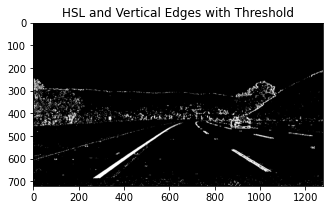

In [42]:
def edgeDetection_1D_wThreshold(mymyImage, orientation='horizontal', kernelSize = 3, threshold = (0, 255)):
    grayMymyImage = cv2.cvtColor(mymyImage, cv2.COLOR_BGR2GRAY)

    if orientation == 'horizontal':
        sobelmyImage = cv2.Sobel(grayMymyImage, cv2.CV_64F, 0, 1, kernelSize)
    elif orientation == 'vertical':
        sobelmyImage = cv2.Sobel(grayMymyImage, cv2.CV_64F, 1, 0, kernelSize)

    absSobelmyImage = np.abs(sobelmyImage)

    scaledSobelmyImage = np.uint8(255*absSobelmyImage/np.max(absSobelmyImage))

    thresholdSobelmyImage =  np.zeros_like(scaledSobelmyImage)
    thresholdSobelmyImage[(scaledSobelmyImage >= threshold[0]) & (scaledSobelmyImage <= threshold[1])] = 1
    
    return thresholdSobelmyImage

def hls_wThreshold(myImage, thresh= (0,255)):
    hlsmyImage = cv2.cvtColor(myImage, cv2.COLOR_RGB2HLS)
    s_channel_hslmyImage = hlsmyImage[:,:,2]

    thresholdSobelmyImage = np.zeros_like(s_channel_hslmyImage)
    thresholdSobelmyImage[(s_channel_hslmyImage > thresh[0]) & (s_channel_hslmyImage <= thresh[1])] = 1
    
    return thresholdSobelmyImage

combined = Functions.hsl_and_verticalEdges_wThreshold(myImage)

f, ax = plt.subplots(figsize=(12, 3))
ax.imshow(combined, cmap="gray")
ax.set_title('HSL and Vertical Edges with Threshold')


# Step 3: Perspective Transform

In [43]:

straightLinesImage = cv2.imread("test_images/straight_lines2.jpg")
straightLinesImage = cv2.cvtColor(straightLinesImage, cv2.COLOR_BGR2RGB)

height = straightLinesImage.shape[0]
width = straightLinesImage.shape[1]

source_topLeft = (592, 450)         
source_bottomLeft = (180, height)      
source_bottomRight = (1130, height)    
source_topRight = (687, 450)  
sourcePoints = np.array([[source_topLeft, source_bottomLeft, source_bottomRight, source_topRight]]).astype('float32')

destination_topLeft = (240, 0)         
destination_bottomLeft = (240, height)      
destination_bottomRight = (1040, height)    
destination_topRight = (1040, 0) 
destiantionPoints = np.array([[destination_topLeft, destination_bottomLeft, destination_bottomRight, destination_topRight]]).astype('float32')

transformMatrix = cv2.getPerspectiveTransform(sourcePoints, destiantionPoints)
inverseTransformMatix = cv2.getPerspectiveTransform(destiantionPoints, sourcePoints)

src_image = np.copy(straightLinesImage)
src_image = cv2.polylines(src_image, sourcePoints.astype('int32'), 1, (255,0,0), thickness=6)

In [44]:
def perspectiveTransform(myImage, transformMatix):
    imageSize = (myImage.shape[1], myImage.shape[0])
    transformedImage = cv2.warpPerspective(myImage, transformMatix, imageSize, flags=cv2.INTER_LINEAR)
    return transformedImage


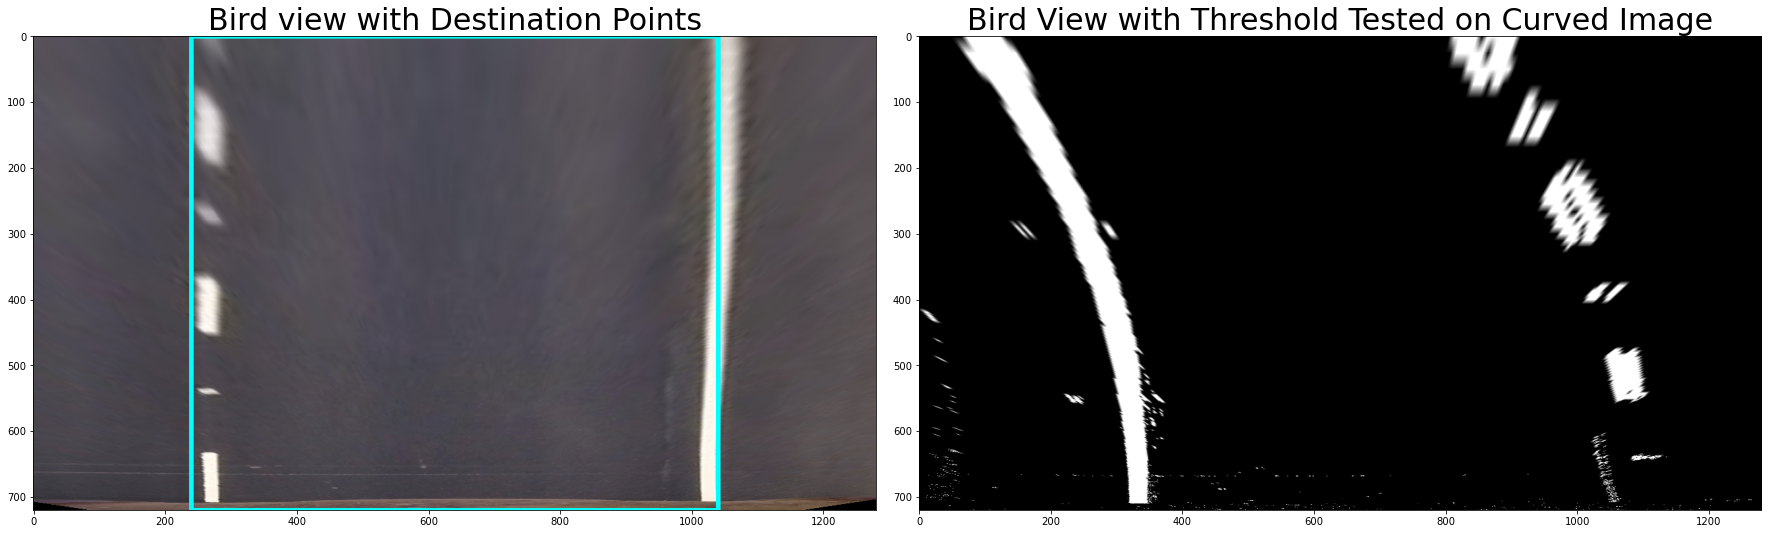

In [45]:
src_image1 = np.copy(straightLinesImage)
src_image1 = cv2.polylines(src_image1, sourcePoints.astype('int32'), 1, (0,255,255), thickness=6)

transfered_image1 = np.copy(straightLinesImage)
transfered_image1 = perspectiveTransform(transfered_image1, transformMatrix)
transfered_image1 = cv2.polylines(transfered_image1, destiantionPoints.astype('int32'), 1, (0,255,255), thickness=6)

src_image2 = cv2.imread("test_images/test2.jpg")
src_image2 = cv2.cvtColor(src_image2, cv2.COLOR_BGR2RGB)

thresholdImage = Functions.hsl_and_verticalEdges_wThreshold(src_image2)

transfered_image2 = np.copy(thresholdImage)
transfered_image2 = perspectiveTransform(transfered_image2, transformMatrix)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(transfered_image1)
ax1.set_title('Bird view with Destination Points', fontsize=30)
ax2.imshow(transfered_image2, cmap = "gray")
ax2.set_title('Bird View with Threshold Tested on Curved Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Step 4: Sliding Window

Text(0.5, 1.0, 'Sliding Window on Transformed Image')

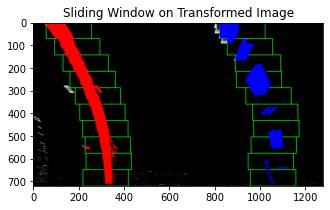

In [46]:
def fitCurve(LX, LY, RX, RY):

    leftCurve = np.polyfit(LY, LX, 2)
    rightCurve =  np.polyfit(RY, RX, 2)
    return leftCurve, rightCurve

def generatePlottingValues(leftCurve, rightCurve, myImageShape):
    pointYaxis = np.linspace(0, myImageShape[0]-1, myImageShape[0])
    
    leftXvalues =  np.polyval(leftCurve, pointYaxis)
    rightXvalues = np.polyval(rightCurve, pointYaxis)
    
    return pointYaxis, leftXvalues, rightXvalues
def slidingWindow(perspectiveTransformmyImage, windowsNUM = 10, margin = 100, threshold = 50):
    
    h = perspectiveTransformmyImage.shape[0]
    w = perspectiveTransformmyImage.shape[1]
    
    outImg = np.dstack((perspectiveTransformmyImage, perspectiveTransformmyImage, perspectiveTransformmyImage))*255

    histogram = np.sum(perspectiveTransformmyImage[int(h/2):, :], axis=0)
       
    listLeftLaneIndices = []
    listRightLaneIndices = [] 
    xCurrLeft = np.argmax(histogram[:int(w/2)])                #leftPeak
    xCurrRight = np.argmax(histogram[int(w/2):]) + int(w/2)    #rightPeak
    
    winHeight = int(h/windowsNUM) 
    
    nonZero2DIndices = np.nonzero(perspectiveTransformmyImage)
    nonZeroYindices = nonZero2DIndices[0]
    nonZeroXindicies = nonZero2DIndices[1]

    for win in range(windowsNUM):

        winYlowerBound = h - (win + 1) * winHeight      
        winYupperBound = h - win * winHeight       
        
        winXlowerBoundLeft = xCurrLeft - margin       
        winXupperBoundLeft =  xCurrLeft + margin
        winXlowerBoundRight = xCurrRight - margin
        winXupperBoundRight = xCurrRight + margin

        cv2.rectangle(outImg,(winXlowerBoundLeft,winYlowerBound),(winXupperBoundLeft,winYupperBound),(0,255,0), 2) 
        cv2.rectangle(outImg,(winXlowerBoundRight,winYlowerBound),(winXupperBoundRight,winYupperBound),(0,255,0), 2)
        
        nonZeroLeft_withinWindow = np.nonzero(((nonZeroYindices >= winYlowerBound) & (nonZeroYindices < winYupperBound) 
                          & (nonZeroXindicies >= winXlowerBoundLeft) & (nonZeroXindicies < winXupperBoundLeft)))[0]

        nonZeroRight_withinWindow = np.nonzero(((nonZeroYindices >= winYlowerBound) & (nonZeroYindices < winYupperBound) 
                          & (nonZeroXindicies >= winXlowerBoundRight)  & (nonZeroXindicies < winXupperBoundRight)))[0]
        
        listLeftLaneIndices.append(nonZeroLeft_withinWindow)
        listRightLaneIndices.append(nonZeroRight_withinWindow)
        
        if len(nonZeroLeft_withinWindow) > threshold:
            xCurrLeft = np.mean(nonZeroXindicies[nonZeroLeft_withinWindow]).astype('int')

        if len(nonZeroRight_withinWindow) > threshold:
            xCurrRight = np.mean(nonZeroXindicies[nonZeroRight_withinWindow]).astype('int')
        
    listLeftLaneIndices = np.concatenate(listLeftLaneIndices)
    listRightLaneIndices = np.concatenate(listRightLaneIndices)
    
    LX = nonZeroXindicies[listLeftLaneIndices]
    LY = nonZeroYindices[listLeftLaneIndices]
    RX = nonZeroXindicies[listRightLaneIndices]
    RY = nonZeroYindices[listRightLaneIndices]

    leftCurve = np.polyfit(LY, LX, 2)
    rightCurve = np.polyfit(RY, RX, 2)

    outImg[nonZeroYindices[listLeftLaneIndices], nonZeroXindicies[listLeftLaneIndices]] = [255, 0, 0]
    outImg[nonZeroYindices[listRightLaneIndices], nonZeroXindicies[listRightLaneIndices]] = [0, 0, 255]

    return LX, LY, RX, RY, outImg

LX, LY, RX, RY, outImg = slidingWindow(transfered_image2)
f, ax = plt.subplots(figsize=(12, 3))
ax.imshow(outImg)
ax.set_title('Sliding Window on Transformed Image')


# Step 5: Curve Fitting

Text(0.5, 1.0, 'Curve Fitting')

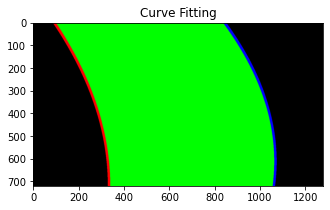

In [47]:
def markLane(myImage, leftCurve, rightCurve, Inverse_transformMatix):
    zerosmyImage = np.zeros_like(myImage[:,:,0]).astype('uint8')
    colormyImageZero = np.dstack((zerosmyImage, zerosmyImage, zerosmyImage))
    
    y, xLeft, xRight = generatePlottingValues(leftCurve, rightCurve, myImage.shape)

    pointLeft = np.array([np.transpose(np.vstack([xLeft, y]))])
    pointRight = np.array([np.flipud(np.transpose(np.vstack([xRight, y])))])
    points = np.hstack((pointLeft, pointRight))
    

    cv2.fillPoly(colormyImageZero, np.int_([points]), (0,255, 0))
    cv2.polylines(colormyImageZero, np.int_([pointRight]), False, (0,0,255),10)
    cv2.polylines(colormyImageZero, np.int_([pointLeft]), False, (255,0,0),10)

    lanesInverseTransferedmyImage = cv2.warpPerspective(colormyImageZero, Inverse_transformMatix, (myImage.shape[1], myImage.shape[0])) 
    
    combined = cv2.addWeighted(myImage, 1, lanesInverseTransferedmyImage, 0.3, 0)
   
    return combined, colormyImageZero

LF, RF = fitCurve(LX, LY, RX, RY)

markedImageCombined, markLaneImg = markLane(myImage, LF, RF, inverseTransformMatrix)

f, ax = plt.subplots(figsize=(12, 3))
ax.imshow(markLaneImg)
ax.set_title('Curve Fitting')